### **Loan Default Prediction**

---

#### **Introduction**

In the financial sector, particularly in lending institutions, assessing the creditworthiness of loan applications is a critical process that directly impacts the profitability and stability of banks. Home equity loans, which allow homeowners to borrow against the equity in their property, carry inherent risks due to the possibility of borrower default. This is the reason why lenders must carefully evaluate the likelihood that the borrower will repay it back or not before approving a loan as this evaluation is crucial because if too many borrowers fail to repay their loans, it can lead to significant financial lossess for the lender. 

The Home Equity dataset (HMEQ) contains detailed information about recent home equity loan applications. It includes data such as the loan amount requested, the applicant's employment history, credit background, and whether they eventually defaulted on the loan or not.

This projects aim to use this dataset to build tools that help banks make smarter lending decisions. By combining data analysis and machine learning techniques with human expertise, we can improve the accuracy of credit assessments and reduce the number of loans that are not repaid.

---

#### **Problem Identification**

One of the biggest challenges in lending is identifying which applicants are likely to repay their loans and which may default. If this is not done correctly, banks can suffer large financial losses due to non-performing loans (NPL), which are loans that are not being paid back as agreed. Currently, banks still rely on manual review by loan officers to decide who gets approved. While experienced reviewers are valuable, this method has some key limitations such as:

- It can be slow and difficult to scale.

- Decisions may vary between different reviewers.

- Human judgement can sometimes be influenced by unconscious biases. 

- Important patterns in the data may be missed due to complexity or volumes of applications. 


These issues can result in poor lending decisions, either approving risky applications or rejecting reliable ones.

---

#### **Project Objectives**

Our main objective is to develop an effective and reliable system that helps banks assess the risk of loan defaults among home equity loan applicants using data-driven methods. These are the objectives and goals that we aim to do:

1. To make analysis on the Home equity loan dataset and identify the most important factors that influence whether a borrower will repay or default.

2. To build and test classification machine learning models to predict clients who are likely to default on their loans.

3. To clean and prepare the dataset for modeling to ensure accurate results.

4. To avoid the risk of misclassification of default loans predicted as non-default as this results in high losses. 

---

#### **Dataset Description**

The Home Equity Loans (HMEQ) dataset contains detailed information on 5,960 recent home equity loan applications . It was collected to help lenders understand and predict which applicants are more likely to default (fail to repay) or repay their loans successfully. This dataset includes both demographic and financial details about each applicant, making it suitable for use in credit risk modeling, loan approval decisions, and predictive analytics.

- **Total Records**: 5,960 recent home equity loan applications.

- **Default Rate**: Approximately 20% (1189 out of 5960 applicants defaulted).

- **Type of Variability**: Loan Financial Varaibles,  Purpose and Employment Variables, and Credit History Variables. In total, there are 12 features and 1 target variable.

- **Target Variable**: `Bad` indicates whether the borrower defaulter (1) or repaid (0). 

<br>

| Variable  | Description                                                                 |
|-----------|-----------------------------------------------------------------------------|
| BAD       | 1 = Client defaulted ; 0 = Loan repaid on time                                     |
| LOAN      | Amount of the laon approved for the home equity loan                                             |
| MORTDUE   | Amount still due on the existing mortgage                                  |
| VALUE     | Current market value of the property                                       |
| REASON    | Purpose of the loan: HomeImp = home improvement, DebtCon = debt consolidation |
| JOB       | Type of job held by applicant                                              |
| YOJ       | Number of years at current job                                                       |
| DEROG     | Number of major derogatory reports (late payments, collections, charge-offs), indicates past credit problems          |
| DELINQ    | Number of delinquent credit lines (a credit line become delinquent when minimum payments are missed for 30-60+ days)                                    |
| CLAGE     | Age of oldest credit line in months (a credit line is a reusable loan that lets you borrow money up to certain limit)                                    |
| NINQ      | Number of recent credit inquiries (Each time a lender pulls credit report)                                       |
| CLNO      | Total number of credit lines currently open (how many accounts the borrower is managing)                               |
| DEBTINC   | Debt-to-income ratio (%), measure the borrower's ability to manage monthly payments         |

#### **Setup and Import necessary libraries**

In [34]:
# Data manipulation and visualization 
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go  
import missingno as msno
import shap 

# Data preprocessing 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Cross-validation and evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Model saving
import pickle
import joblib


#### **Data understanding**

In [2]:
# Read the dataset 
path = "../data/raw/home_equity_loan_applications.csv"
df = pd.read_csv(path)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [3]:
# Check the basic information about the data
print(f"Shape of the dataset: ", df.shape)
df.info()

Shape of the dataset:  (5960, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [4]:
# Check for missing values and duplicated rows
missing_values = np.round(df.isnull().sum() / len(df) * 100, 2)
print("Percentage of missing values in each column:")
print(missing_values.astype(str) + " %")
print()

duplicated_rows = df.duplicated().sum()
print("Number of duplicated rows: ", duplicated_rows)

Percentage of missing values in each column:
BAD          0.0 %
LOAN         0.0 %
MORTDUE     8.69 %
VALUE       1.88 %
REASON      4.23 %
JOB         4.68 %
YOJ         8.64 %
DEROG      11.88 %
DELINQ      9.73 %
CLAGE       5.17 %
NINQ        8.56 %
CLNO        3.72 %
DEBTINC    21.26 %
dtype: object

Number of duplicated rows:  0


<Axes: >

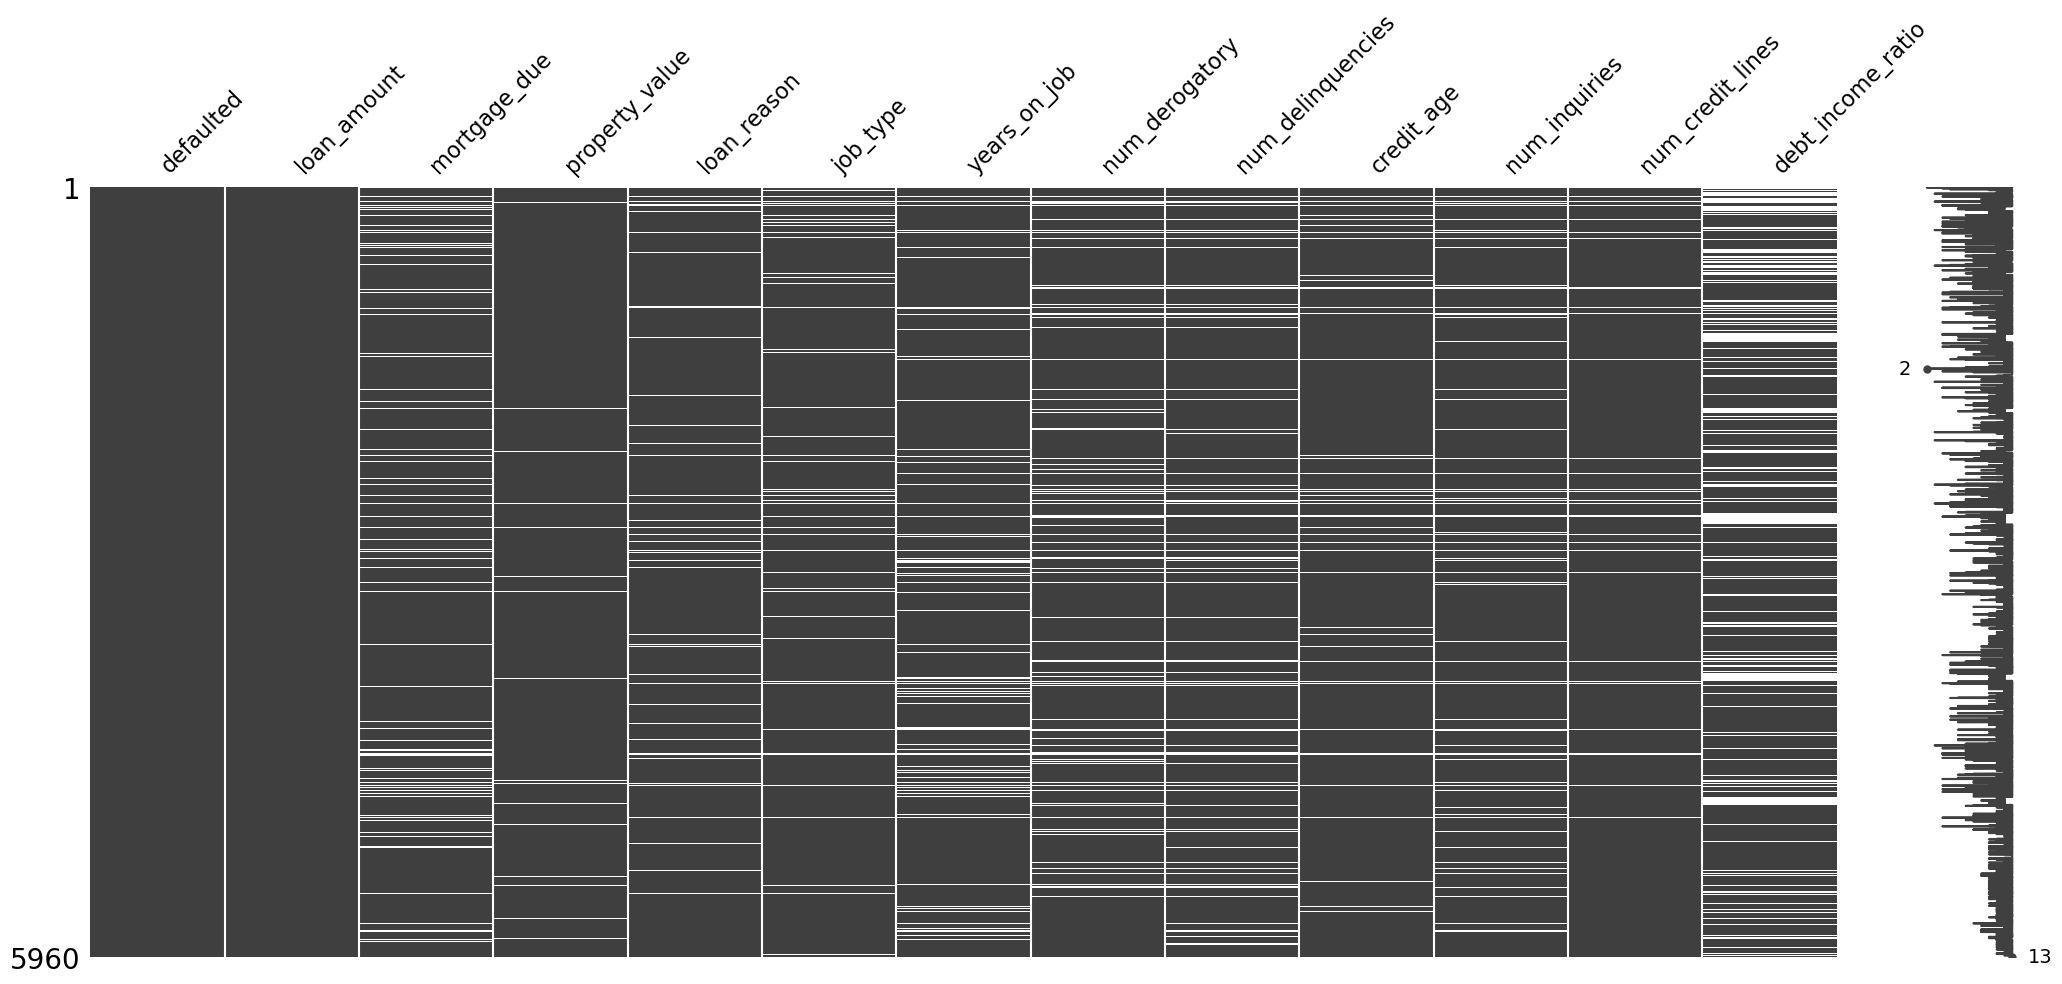

In [ ]:
# Plot the distribution of missing values
msno.matrix(df)

**Findings**: Based on the information from the dataset, there are 13 columns within the table with 1 target variable and 12 features, having a total number of rows of 5960. Here is the characteristic of the dataset: 

- The dataset contains floating, integer, and object data type. 

- There are 11 columns that have missing values. The column with the highest missing values is `DEBTINC` accounted for 21.26% of the total data points, followed by `DEROG` that accounted for 11.88%, which means we need to do imputation. 

- There are no duplicated rows within the dataset, so there is no need to drop duplication.

- The dataset column names are hard to understand, so we might need to rename them accordingly.

In [5]:
# Get the categorical and numerical features 
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical features: ", numerical_features)
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.append("BAD")
print("Categorical features: ", categorical_features)

Numerical features:  ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
Categorical features:  ['REASON', 'JOB', 'BAD']


In [6]:
# Change the target variable and object to categorical
for col in categorical_features:
    df[col] = df[col].astype('category')

In [7]:
# Check summary statistics for object columns
df.describe(include="category")

,BAD,REASON,JOB
count,5960,5708,5681
unique,2,2,6
top,0,DebtCon,Other
freq,4771,3928,2388


In [8]:
# Check the unique values in each categorical column
for col in categorical_features:
    print(df[col].value_counts())
    print()

REASON
DebtCon    3928
HomeImp    1780
Name: count, dtype: int64

JOB
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: count, dtype: int64

BAD
0    4771
1    1189
Name: count, dtype: int64



**Findings**: There are three categorical columns in the dataset such as `REASON`, `JOB`, and `BAD`. 

- `BAD`: The target variable is imbalanced which is true in reality for loan application dataset. Only around 20% were defaulted loans. So, we need to apply the right data handling on imbalanced class so as to not create noise and bias.

- `REASON`: There are two unique values within the reason column, and most of them is *DebtCon* (Loan to pay off other existing debts) which accounted about 65% and the rest is *HomeImp* (Loan for home improvement).

- `JOB`: There are six unqiue values within the job column. Most of them is *Other* without specific title, followed by *ProfExe*, *Office*, *Mgr*, *Self*, *Sales*.

In [9]:
# Check summary statistics for numerical columns
df.describe(include=["int64", "float64"])

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


**Findings**: Given the nature of financial data, it is expected that many numerical variables in the dataset exhibit right-skewed distributions . In such cases, a small number of applicants have significantly higher values, but these are typically legitimate variations among borrowers rather than errors or outliers. From the statistical summary, we are able to see several key insights into the financial profiles of home equity loan applicants.

- Loan Amounts - `LOAN`: 

    - The average loan amount is around $18,608, with most applicants requesting between $1,100 and $23,300. 

    - However, there is at least one very large loan of nearly $89,900, indicating a right-skewed distribution. 

- Mortgage Due  - `MORTDUE`: 

    - The average mortgage due amount is $73,761, but the minimum is $2,063, and maximum goes up to nearly $400,000. 
    
    - This indicates right skeweness with extreme values after the upper quartile. 

- Property Value  - `VALUE`: 

    - On average, homes are valued at about $100,000, with the majority of the data points fall between $8,000 and around $120,000, but the maximum is $855,909.

    - This indicates right skewness with a diverse set of applicants, including both modest and high-value properties.

    - The property value and mortgage value are crucial factors for lenders to calculate the loan amounts that can be given to the borrowers. 

- Year of Job  - `YOJ`: 

    - On average, applicants have been at their for about 9 years, though some have just started with 0 years at their current work.

- Derogatory Reports - `DEROG` and Delinquency - `DELINQ`:

    - Many applicants have no derogatory reports or delinquencies as most of them have 0 record, but some have up to 10 and 15.

    - This indicates that some applicants have bad past credit histories. 

- Credit Line Age in Months  - `CLAGE`: 

    - The average credit line age is around 180 months which is around 15 years, showing long credit history. 

    - The highest credit line age is about 1168 months which is around 97 years, which is needed to be studied further, preventing case of outliers.


- Number of Credit Inquiries  - `NINQ`: 

    - On average, 1 credit inquiries occured for each applicant. But we can see that some applicants have up t0 17 inquiries.

    - This indicates a warning that there might be something happening for this applicant credit.

- Number of Credit Lines - `CLNO`:

    - Most applicants on average have 21 credit lines with the majority fall between 0 to 26 credit lines (75%).

    - The highest credit line is 71, extremely far from the upper quartile. 

- Debt-to-Income Ratio  - `DEBTINC`: 

    - The average debt-to-income ratio is approximately 33.8% , which is relatively high, suggesting many applicants have significant monthly debt obligations. 

    - Some applicants show extremely high ratios (up to 203% ), indicating potential financial stress.


**Key Takeaways**: These findings suggest that while most applicants fall within typical financial ranges, a number of cases have extreme values that may affect model performance if not handled properly. Tree-based models  are recommended due to their robustness to skewed data.

#### **Exploratory Data Analysis**

After the first stepn of exploring the dataset, we are now able to get a good overview of the general information about the home equity loan dataset. In this step, we are going to check and analyze the data further to extend our studies on the factors that can contribute to defaulting. We will have guiding questions that we want to answers to gain insights from the dataset.

**Guiding Questions**:

1. How balanced is the target variable?

2. Which features have missing values, and could missingness be informative?

3. Do job type and loan reason show strong correlation with defaulting?

4. What numerical features are most different between defaulters and non-defaulters?

5. Does higher loan amount correlate with increased in default risk?

6. How does the relationship between mortgage balance and property value affect default?

7. Is there a threshold in debt-ratio income that increases default risk?

8. What are the correlation between derogatory reports and defaulted?

9. How does credit line history differ between defaulting and no defaulting loans?


In [10]:
# Rename the columns stored in a dictionary
renames = {
    "LOAN": "loan_amount",
    "MORTDUE": "mortgage_due",
    "VALUE": "property_value",
    "REASON": "loan_reason",
    "JOB": "job_type",
    "YOJ": "years_on_job",
    "DEROG": "num_derogatory",
    "DELINQ": "num_delinquencies",
    "CLAGE": "credit_age",
    "NINQ": "num_inquiries",
    "CLNO": "num_credit_lines",
    "DEBTINC": "debt_income_ratio",
    "BAD": "defaulted"
}
df.rename(columns=renames, inplace=True)

# Check the new column names
df.columns.tolist()


['defaulted',
 'loan_amount',
 'mortgage_due',
 'property_value',
 'loan_reason',
 'job_type',
 'years_on_job',
 'num_derogatory',
 'num_delinquencies',
 'credit_age',
 'num_inquiries',
 'num_credit_lines',
 'debt_income_ratio']

#### **Univariate Analysis**

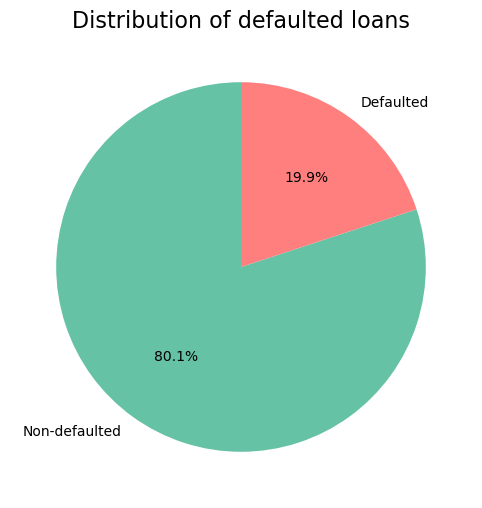

In [35]:
# Find the values of each target class
defaulted_dist = df["defaulted"].value_counts().reset_index()
labels = {0: "Non-defaulted", 1: "Defaulted"}
defaulted_dist["defaulted"] = defaulted_dist["defaulted"].map(labels)

# Plot with pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    defaulted_dist["count"], 
    labels=defaulted_dist["defaulted"], 
    autopct='%1.1f%%', startangle=90, 
    colors=["#66c2a5", "#FF7F7F"])
plt.title("Distribution of defaulted loans", fontsize=16)
plt.show()

**Findings**: From this pie chart, we are able to clearly see that the target variable is highly imbalanced as most of the applications are non-defaulted loans, which means that we need to apply technqiues to handle this class imbalancing.

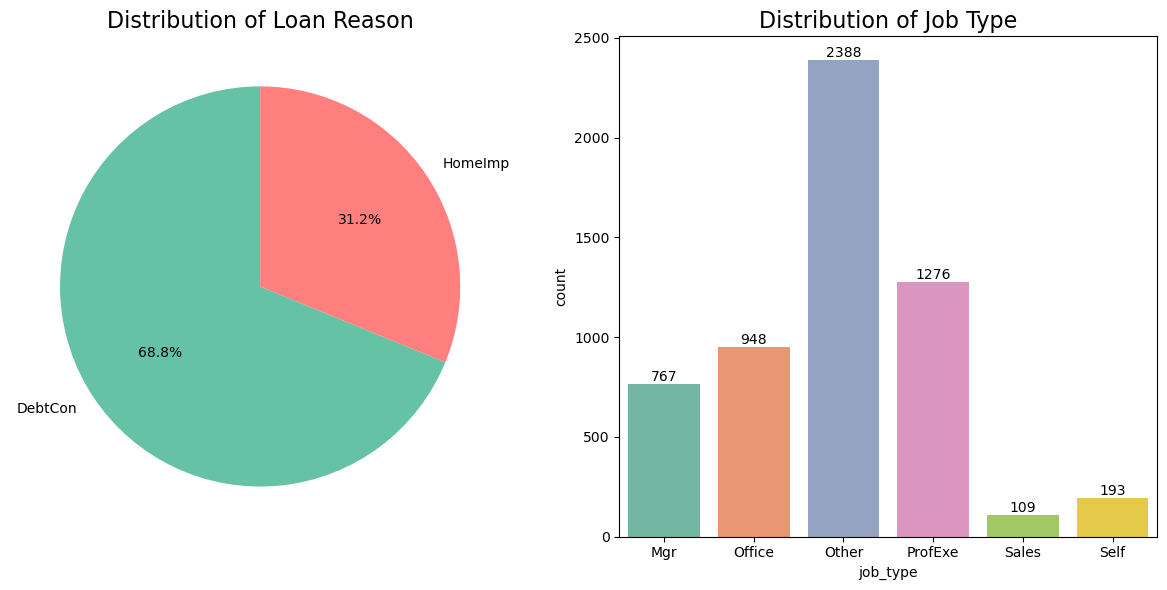

In [13]:
# Find the values of each class in job type and loan reason
job_dist = df["job_type"].value_counts().reset_index()
loan_reason_dist = df["loan_reason"].value_counts().reset_index()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Pie chart for loan reason
axes[0].pie(
    loan_reason_dist["count"],
    labels=loan_reason_dist["loan_reason"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66c2a5", "#FF7F7F"]
)
axes[0].set_title("Distribution of Loan Reason", fontsize=16)

# Bar chart for job type
sns.barplot(ax=axes[1], data=job_dist, 
            x="job_type", y="count", 
            hue="job_type", palette="Set2")  
axes[1].set_title("Distribution of Job Type", fontsize=16)
for container in axes[1].containers:
    axes[1].bar_label(container)

# Adjust layout
plt.tight_layout()
plt.show()

**Findings**: Based on the distribution of the two graphs above, we can see that:

- `loan_reason`: Most of the loan reasons are due to debt consolidation, which means that the borrowers took out the home equity loan to pay off another existing loans. 

    - 68.8% of the applications are debt consolidation while 31.2% are for home improvement.

    - Based on our assumption, loan applications with debt consolidation might have higher chance of default than home improvement as the applicants may have a lot of loan in hands.

- `job_type`: A large portion of the applicants do not contain any specific job type as the other value contains around 40% of the total applicants.

    - Followed by professor/executive, officer and manager. Sales and self-employed have the lowest portion. 

    - Different job type may lead to different salary which can affect the ability of the applicants to repay the loan.

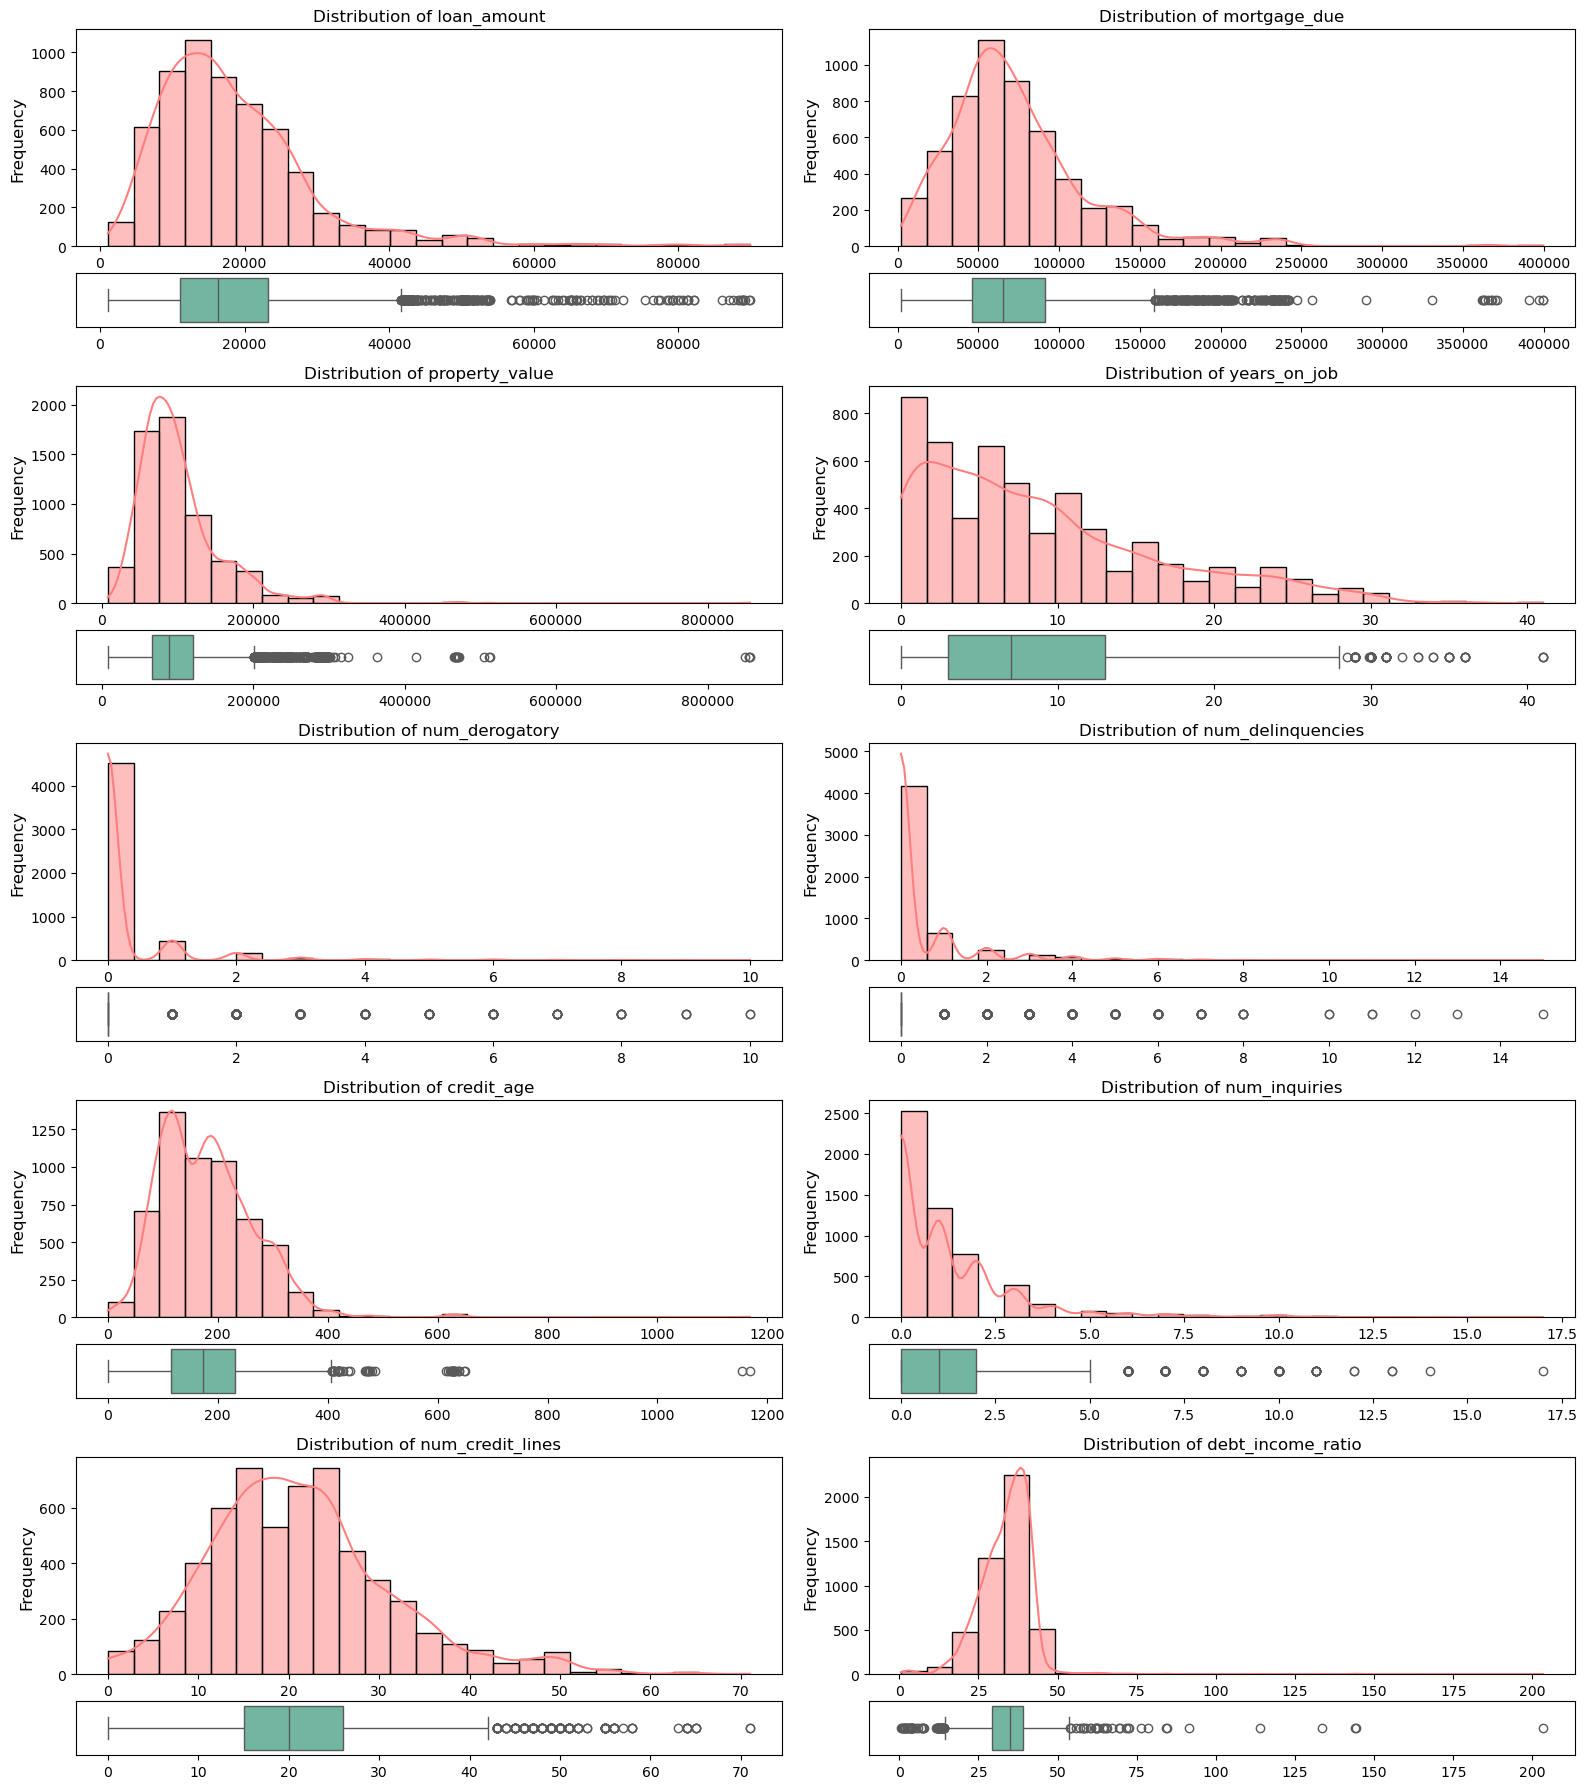

In [ ]:
# Check the distribution of each numerical feature 
fig = plt.figure(figsize=(16, 18))
plt.subplots_adjust(hspace=0.7)

for i, column in enumerate(numerical_features):
    
    # Use GridSpec to stack histogram and boxplot vertically in each subplot
    outer = gridspec.GridSpec(5, 2, figure=fig)[i]
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer, height_ratios=[4, 1])

    # Histogram with KDE
    ax0 = fig.add_subplot(inner[0])
    sns.histplot(df[column], bins=25, kde=True, ax=ax0, color="#FF7F7F")
    ax0.set_title(f"Distribution of {column}", fontsize=12)
    ax0.set_xlabel(column, fontsize=12)
    ax0.set_ylabel("Frequency", fontsize=12)

    # Boxplot 
    ax1 = fig.add_subplot(inner[1], sharex=ax0)
    sns.boxplot(x=df[column], ax=ax1, color="#66c2a5", orient="h")
    ax1.set_xlabel("")
    ax1.set_yticks([])

plt.tight_layout()
plt.show()

In [43]:
# Check the outliers percentage 
def outlier_percentage(feature):
    # Calculate the range 
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Define the outliers
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_percentage = len(outliers) / len(df) * 100

    return outlier_percentage

for feature in numerical_features:
    percentage = outlier_percentage(feature)
    print(f"Percentage of outliers in {feature}: {percentage:.2f}%")

Percentage of outliers in loan_amount: 4.30%
Percentage of outliers in mortgage_due: 3.93%
Percentage of outliers in property_value: 5.37%
Percentage of outliers in years_on_job: 1.53%
Percentage of outliers in num_derogatory: 12.16%
Percentage of outliers in num_delinquencies: 20.15%
Percentage of outliers in credit_age: 0.79%
Percentage of outliers in num_inquiries: 2.97%
Percentage of outliers in num_credit_lines: 3.67%
Percentage of outliers in debt_income_ratio: 1.58%


In [44]:
df["debt_income_ratio"].skew()

2.8523534162154887

**Findings**

Based on the histograms and boxplots, **none of the numerical features follow a normal distribution**. Most exhibit **right skewness**, with a concentration of values in the lower ranges and a long tail extending to the right. Below is a breakdown of key observations for each feature:

- **`loan_amount`**: The majority of loan amounts are below **$40,000**, while **4.3%** of values exceed this threshold and are considered outliers.

- **`mortgage_due`**: This feature shows a similar pattern to `loan_amount`, with most values under **$150,000**. Outliers represent **approximately 3.93%** of the data.

- **`property_value`**: About **95%** of the property values are less than **$200,000**, with higher values treated as potential outliers.

- **`years_on_job`**: Nearly **99%** of applicants report job tenure of fewer than **30 years**, indicating very few have significantly longer work histories.

- **`num_derogatory`** and **`num_delinquencies`**: Most applicants report **zero** derogatory marks or delinquencies, reflecting good credit history. However, **12.16%** and **20.15%** of the values exceed 0 and are flagged as outliers, respectively.

- **`credit_age`**: Only **0.79%** of applicants have a credit history longer than **400 months**, suggesting such long histories are rare.

- **`num_inquiries`**: Around **2.97%** of applicants made more than **5 inquiries**, showing that most applicants had limited recent credit checks.

- **`num_credit_lines`**: Applicants with more than **43 credit lines** make up about **3.67%** of the dataset and are considered outliers.

- **`debt_income_ratio`**: The typical range spans from **13 to 52**. Values beyond this range account for only **1.58%** of the data, indicating that high debt-to-income ratios are uncommon.

**Key Takeaway**

While outliers are present across most numerical features, they do not necessarily represent data errors. In fact, extreme values—such as high loan amounts, numerous derogatory marks, or large property values—can reflect real-world financial conditions. Therefore:

- **Capping or removing these outliers may not be appropriate**, especially if they carry predictive significance.
- If using **tree-based models**, **outliers can be retained**, as these models are inherently robust to them and may leverage the extremes to identify risk patterns associated with defaults.


#### **Bivariate Analysis**

- Compare on how different job and loan reason affect defaulting - bar chart 

- Check the correlation between loan amount with defaulting - box plot

- Check the correlation between mortgage and property with loan amount - scatterplot

- How does home property affect defaulting - box plot 

- Does high years on job mean less defaulting? box plot 

- What if the number of derogatory, delinquencies, and number of credit inquiries, what are the distribution of the defaulting - boxplot

- How does debt income relate with defaulting 